In previous projects, we use TfIdf vectors to represent texts. However, in this project, we intend to leverage topic models, that is to represent each text with a linear combination of topics, which are also vectors.

The scikit-learn version: 0.19.1
In order to simplify the classification, instead of using 20 categories of news, we just relabeled them as 4 major categories.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
%matplotlib inline

In [2]:
#Read data, those data only has for major categories
newsgroups_train = pd.read_csv('news_train.csv')
newsgroups_test = pd.read_csv('news_test.csv')

In [3]:
newsgroups_train.head()

,News,Type,TypeName
0,from eei eeiihy memo ericsson se subject help ...,1,comp.graphics
1,from chrism cirrus com chris metcalfe subject ...,3,comp.sys.ibm.pc.hardware
2,from ekr squick eitech com eric rescorla subje...,0,alt.atheism
3,from bruce liv ac uk bruce stephens subject re...,0,alt.atheism
4,from j david sms business uwo ca james david s...,2,comp.os.ms-windows.misc


## 1.Get TfIdf Vectors

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), max_features=50000)
X_train_tfidf = tfidfVectorizer.fit_transform(newsgroups_train.News)
X_train_tfidf.shape

(8356, 50000)

In [5]:
X_test_tfidf = tfidfVectorizer.transform(newsgroups_test.News)
X_test_tfidf.shape

(5563, 50000)

In [6]:
feature_words = tfidfVectorizer.get_feature_names()

## 2.Extract topics by NMF

In [7]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
from time import time

### NMF Extraction
NMF stands for "Non-negative Matrix Factorization", it is a dimension reduction technique. It can also be viewed as a way to extract topics from original vectors.

In [ ]:
n_components = 30
# Fit the NMF model, suppose there are 10 topics
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5)
nmf.fit(X_train_tfidf)
print("done in %0.3fs." % (time() - t0))

In [13]:
print('The shape of the topic matrix:', nmf.components_.shape)
print(nmf.components_[0, :])

The shape of the topic matrix: (10, 50000)
[ 0.02916862  0.02697153  0.         ...,  0.          0.          0.        ]


We can regard each text as a combination of weighted topic, for some topics the weight are larger whereasw some are small, and those weights can be features to represent the text. And Each topic is a combination of weights of words. Let's check the first compoent, namely the first topic.

In [14]:
for i, component in enumerate(nmf.components_):
    #The most important 20 words' index
    nlargest = component.argsort()[-10:]
    word_list = []
    for n in nlargest:
        word_list.append(feature_words[n])
    print('*'*20)
    print('The ' + str(i) + 'th component:')
    print(word_list)

********************
The 0th component:
['ca', 'subject', 'organization', 'cs', 'just', 'don', 'writes', 'article', 'university', 'edu']
********************
The 1th component:
['life', 'christ', 'christian', 'faith', 'believe', 'christians', 'people', 'bible', 'jesus', 'god']
********************
The 2th component:
['program', 'mouse', 'video', 'use', 'files', 'card', 'file', 'window', 'dos', 'windows']
********************
The 3th component:
['manes', 'criminals', 'police', 'people', 'crime', 'control', 'weapons', 'firearms', 'guns', 'gun']
********************
The 4th component:
['schneider', 'cco', 'jon', 'wpd', 'solntze', 'morality', 'sgi', 'livesey', 'caltech', 'keith']
********************
The 5th component:
['sw', 'cdt', 'ibm', 'writes', 'sun', 'article', 'hp', 'stratus', 'netcom', 'com']
********************
The 6th component:
['mac', 'hard', 'isa', 'drives', 'bus', 'controller', 'mb', 'drive', 'ide', 'scsi']
********************
The 7th component:
['soviet', 'turkey', 'genoci

It looks like the last compoenent is related to computer science, whereas the second one is related to religion. Next, we can extract the features for each news.

In [15]:
#Extract feature for each news
nmf_train_features = nmf.transform(X_train_tfidf)
nmf_test_features = nmf.transform(X_test_tfidf)

In [16]:
nmf_train_features.shape

(8356, 10)

In [17]:
nmf_train_features[0, :]

array([ 0.01755643,  0.        ,  0.01458415,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

### Classify

Based on the extracted features above, we can move forward, use machine learning algorithms to classify those news.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
knn = KNeighborsClassifier(n_neighbors=20,weights='distance')
knn.fit(nmf_train_features, newsgroups_train.Type)
predicted = knn.predict(nmf_test_features)

In [19]:
print('Micro F1: {:.3f}'.format(f1_score(newsgroups_test.Type, predicted, average='micro')))

Micro F1: 0.804


The result is not satisfying, in order to select proper parameters and proper models we need to put two steps together and make a pipeline.

### Pipeline

In [20]:
from sklearn.pipeline import make_pipeline
#Load classification Models
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, alpha=1e-4,
                    solver='sgd', verbose=False, tol=1e-5, random_state=1,
                    learning_rate_init=.17)
nb = MultinomialNB(0.01)
lr = LogisticRegression(C=0.5)
rf =  RandomForestClassifier(n_estimators=100, n_jobs=4)
svc = SVC(C=0.5)
ld = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
models = [nb, lr, rf, svc, ld, mlp]

In [21]:
def make_plot(training_scores, testing_scores, title):
    '''Make plots'''
    plt.title(title)
    plt.plot(training_scores, marker='.', label='Training Score')
    plt.plot(testing_scores, marker='.', label='Testing Score')
    plt.legend()
    plt.ylabel('f1_score')

Start to run <class 'sklearn.naive_bayes.MultinomialNB'>
Start to run <class 'sklearn.linear_model.logistic.LogisticRegression'>
Start to run <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Start to run <class 'sklearn.svm.classes.SVC'>
Start to run <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Start to run <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>


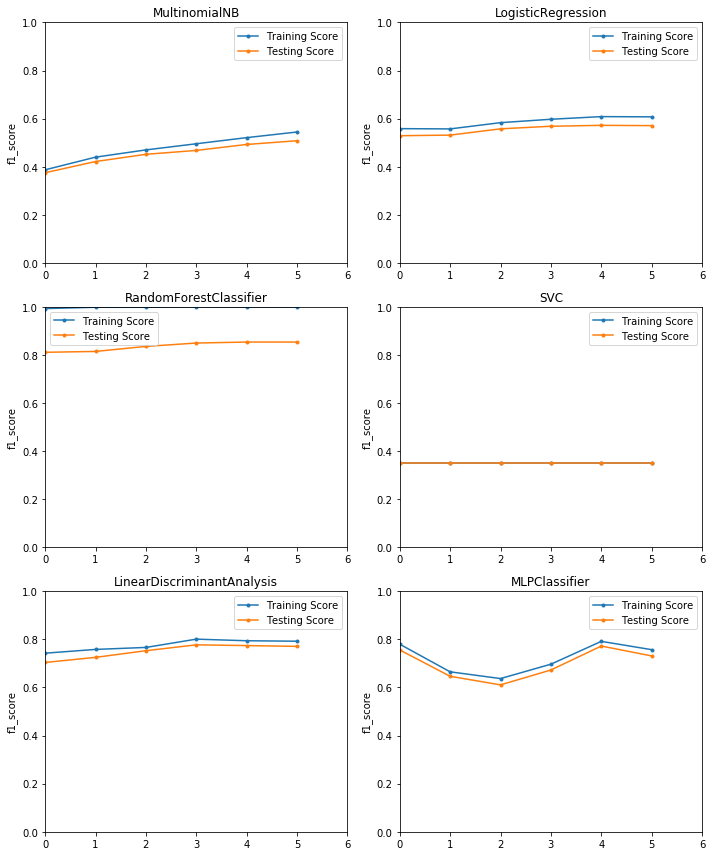

In [112]:
#Specify the number of topics
n_components = [10, 20, 30, 40, 50, 60]
#Traverse each 
plt.figure(figsize=(10, 12))
for i, model in enumerate(models):
    train_scores = []
    test_scores = []
    print('Start to run', str(model.__class__))
    for n_component in n_components:
        nmf = NMF(n_components=n_component, random_state=1,
                  alpha=.1, l1_ratio=.5)
       #Make pipeline to simplify code
        pipeline = make_pipeline(nmf, model)
        pipeline.fit(X_train_tfidf, newsgroups_train.Type)
        train_pred = pipeline.predict(X_train_tfidf)
        test_pred = pipeline.predict(X_test_tfidf)
        test_scores.append(f1_score(newsgroups_test.Type, test_pred, average='micro'))
        train_scores.append(f1_score(newsgroups_train.Type, train_pred, average='micro'))
    plt.subplot(3, 2 , i+1)
    title = str(model.__class__).replace("'>", '').split('.')[-1]
    make_plot(train_scores, test_scores, title)  
    plt.axis((0, 6, 0, 1))
    plt.tight_layout() 

## 3.Extract topics by LDA

In [25]:
lda = LatentDirichletAllocation(n_components =10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(X_train_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [26]:
#Check the most important words within each topic,namely each component
for i, component in enumerate(lda.components_):
    #The most important 20 words' index
    nlargest = component.argsort()[-10:]
    word_list = []
    for n in nlargest:
        word_list.append(feature_words[n])
    print('*'*20)
    print('The ' + str(i) + 'th component:')
    print(word_list)

********************
The 0th component:
['steinbakken', 'kadar', 'ordularinin', 'rus', 'enviroleague', 'idca', 'crnsu', 'apeldoorn', 'aruit', 'ruiter']
********************
The 1th component:
['lippard', 'syllogism', 'gm', 'sculptor', 'franz', 'colorado', 'edu', 'forging', 'schewe', 'reprints']
********************
The 2th component:
['kent', 'jan', 'teen', 'sandvik', 'colvin', 'cdcolvin', 'venkatesh', 'simha', 'rao', 'xrn']
********************
The 3th component:
['ldawes', 'valpso', 'livy', 'rubenstein', 'manfredo', 'tpeng', 'acsddc', 'smucs', 'tichauer', 'umassd']
********************
The 4th component:
['carmo', 'abel', 'riv', 'hkuxa', 'max', 'hku', 'antolovich', 'wagga', 'developable', 'ax']
********************
The 5th component:
['sturm', 'schauf', 'jearls', 'earls', 'lutz', 'burkhard', 'nestvx', 'neidecker', 'bucknell', 'schaufenbuel']
********************
The 6th component:
['varco', 'screamin', 'muenster', 'heinz', 'bobasun', 'bshaw', 'jessea', 'essen', 'xon', 'claes']
******

### Make a pipeline

Next, we will put LDA and classification models together.

Start to run <class 'sklearn.naive_bayes.MultinomialNB'>
Start to run <class 'sklearn.linear_model.logistic.LogisticRegression'>
Start to run <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Start to run <class 'sklearn.svm.classes.SVC'>
Start to run <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Start to run <class 'sklearn.neural_network.multilayer_perceptron.MLPClassifier'>


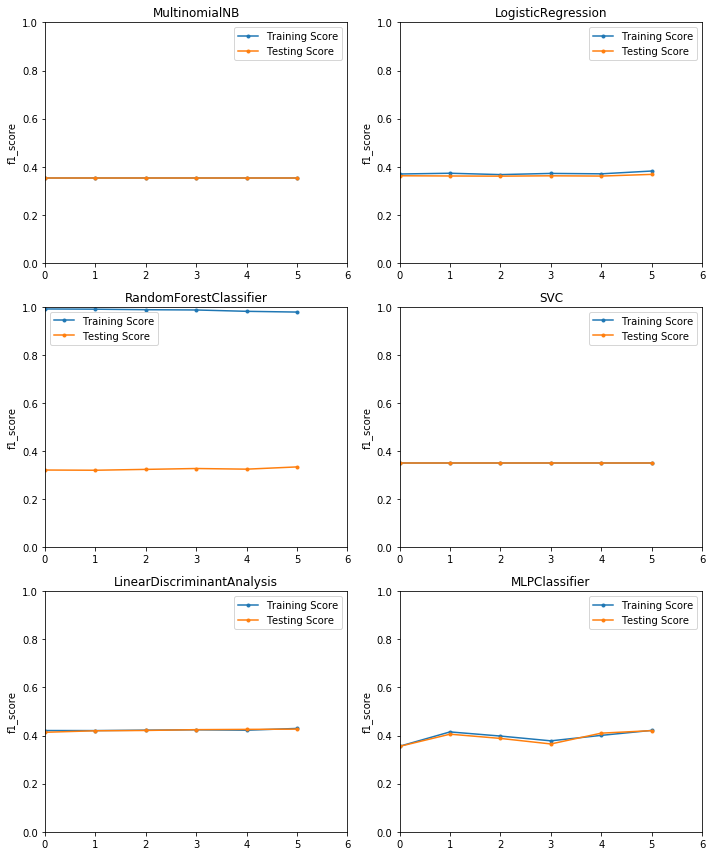

In [29]:
#Specify the number of topics
n_components = [10, 20, 30, 40, 50, 60]
#Traverse each 
plt.figure(figsize=(10, 12))
for i, model in enumerate(models):
    train_scores = []
    test_scores = []
    print('Start to run', str(model.__class__))
    for n_component in n_components:
        lda = LatentDirichletAllocation(n_components =n_component, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
       #Make pipeline to simplify code
        pipeline = make_pipeline(lda, model)
        pipeline.fit(X_train_tfidf, newsgroups_train.Type)
        train_pred = pipeline.predict(X_train_tfidf)
        test_pred = pipeline.predict(X_test_tfidf)
        test_scores.append(f1_score(newsgroups_test.Type, test_pred, average='micro'))
        train_scores.append(f1_score(newsgroups_train.Type, train_pred, average='micro'))
    plt.subplot(3, 2 , i+1)
    title = str(model.__class__).replace("'>", '').split('.')[-1]
    make_plot(train_scores, test_scores, title) 
    plt.axis((0, 6, 0, 1))
    plt.tight_layout() 

It seems the topic models do not work so well as previous bag-of-word model, perhaps due to the noise in the texts, and the text are quite complicated.